In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [5]:
# load previous data
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"

In [6]:
# featurize new Anton trajectories
feat = pyemma.coordinates.featurizer("../../../civsd-pro.pdb")
s158_o = feat.select("residue 158 and name OG")[0]
t197_o = feat.select("residue 197 and name OG1")[0]
r226_cz = feat.select("residue 226 and name CZ")[0]
feat.add_distances(np.array([[s158_o, r226_cz], [t197_o, r226_cz]]))

In [7]:
feat.describe()

['DIST: SER 158 OG 850 - ARG 226 CZ 1947',
 'DIST: THR 197 OG1 1477 - ARG 226 CZ 1947']

In [8]:
# collect files
remove = {
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(295):
    if (i + 1000) not in remove:
        files.append(f"/beagle3/dinner/scguo/anton-old/xtc1000ns/civsd-{i}.xtc")

for i in range(3, 119):
    if i == 82:
        continue
    files.append(f"/project/dinner/scguo/ci-vsd/anton2/prot/civsd.prot.{i}.xtc")

In [9]:
distances = pyemma.coordinates.load(files, features=feat, chunksize=128)

Obtaining file info:   0%|          | 0/352 [00:00<?, ?it/s]

OSError: Could not obtain info for file /beagle3/dinner/scguo/anton-old/xtc1000ns/civsd-22.xtc. Original error was 

In [12]:
# np.save(f"{DATA_DIR}/raw_feat/s158_t197_r226.npy", distances)
distances = np.load(f"{DATA_DIR}/raw_feat/s158_t197_r226.npy", allow_pickle=True)

In [13]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    0
]  # 0.1 ns lag time

In [14]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [15]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Violin plots of torsions

In [16]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [17]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.95)

In [18]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

In [19]:
dist_arr = np.concatenate(distances)

(array([5.72440e+04, 1.33266e+05, 4.64605e+05, 7.61004e+05, 6.11142e+05,
        4.98656e+05, 4.59064e+05, 3.66525e+05, 2.15190e+05, 1.12555e+05,
        9.89260e+04, 1.17023e+05, 1.00196e+05, 7.65630e+04, 4.88170e+04,
        1.94330e+04, 7.04300e+03, 2.52100e+03, 3.26000e+02, 1.60000e+01]),
 array([0.29263467, 0.40160885, 0.51058304, 0.61955726, 0.7285315 ,
        0.83750564, 0.94647986, 1.055454  , 1.1644282 , 1.2734025 ,
        1.3823767 , 1.4913509 , 1.600325  , 1.7092992 , 1.8182734 ,
        1.9272476 , 2.0362217 , 2.145196  , 2.2541702 , 2.3631444 ,
        2.4721186 ], dtype=float32),
 <BarContainer object of 20 artists>)

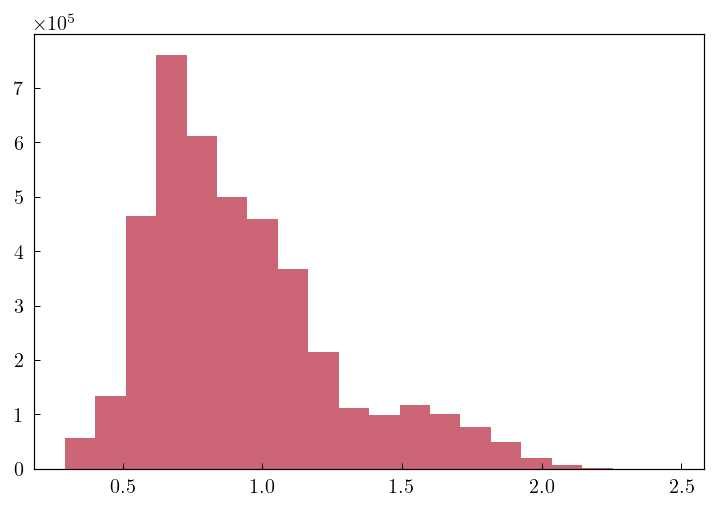

In [20]:
plt.hist(dist_arr[:, 0], bins=20)

(array([1.13270e+05, 3.83139e+05, 4.77540e+05, 4.43713e+05, 4.44476e+05,
        4.44888e+05, 3.05104e+05, 4.61536e+05, 4.72401e+05, 2.03925e+05,
        6.30960e+04, 4.44030e+04, 8.87910e+04, 9.67970e+04, 6.14870e+04,
        2.92140e+04, 1.27830e+04, 3.23500e+03, 2.88000e+02, 2.90000e+01]),
 array([0.3125156 , 0.42883354, 0.5451515 , 0.6614694 , 0.7777874 ,
        0.8941053 , 1.0104233 , 1.1267412 , 1.2430592 , 1.3593771 ,
        1.475695  , 1.592013  , 1.708331  , 1.8246489 , 1.9409668 ,
        2.0572848 , 2.1736028 , 2.2899208 , 2.4062386 , 2.5225565 ,
        2.6388745 ], dtype=float32),
 <BarContainer object of 20 artists>)

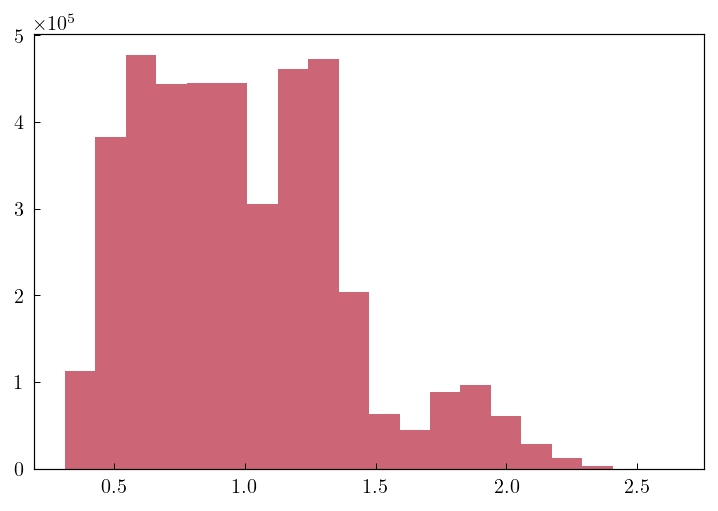

In [46]:
plt.hist(dist_arr[:, 1], bins=20)

Text(0, 0.5, 'R226 C$_\\zeta$-T197 O$_\\gamma$ distance / $\\textrm{\\AA}$')

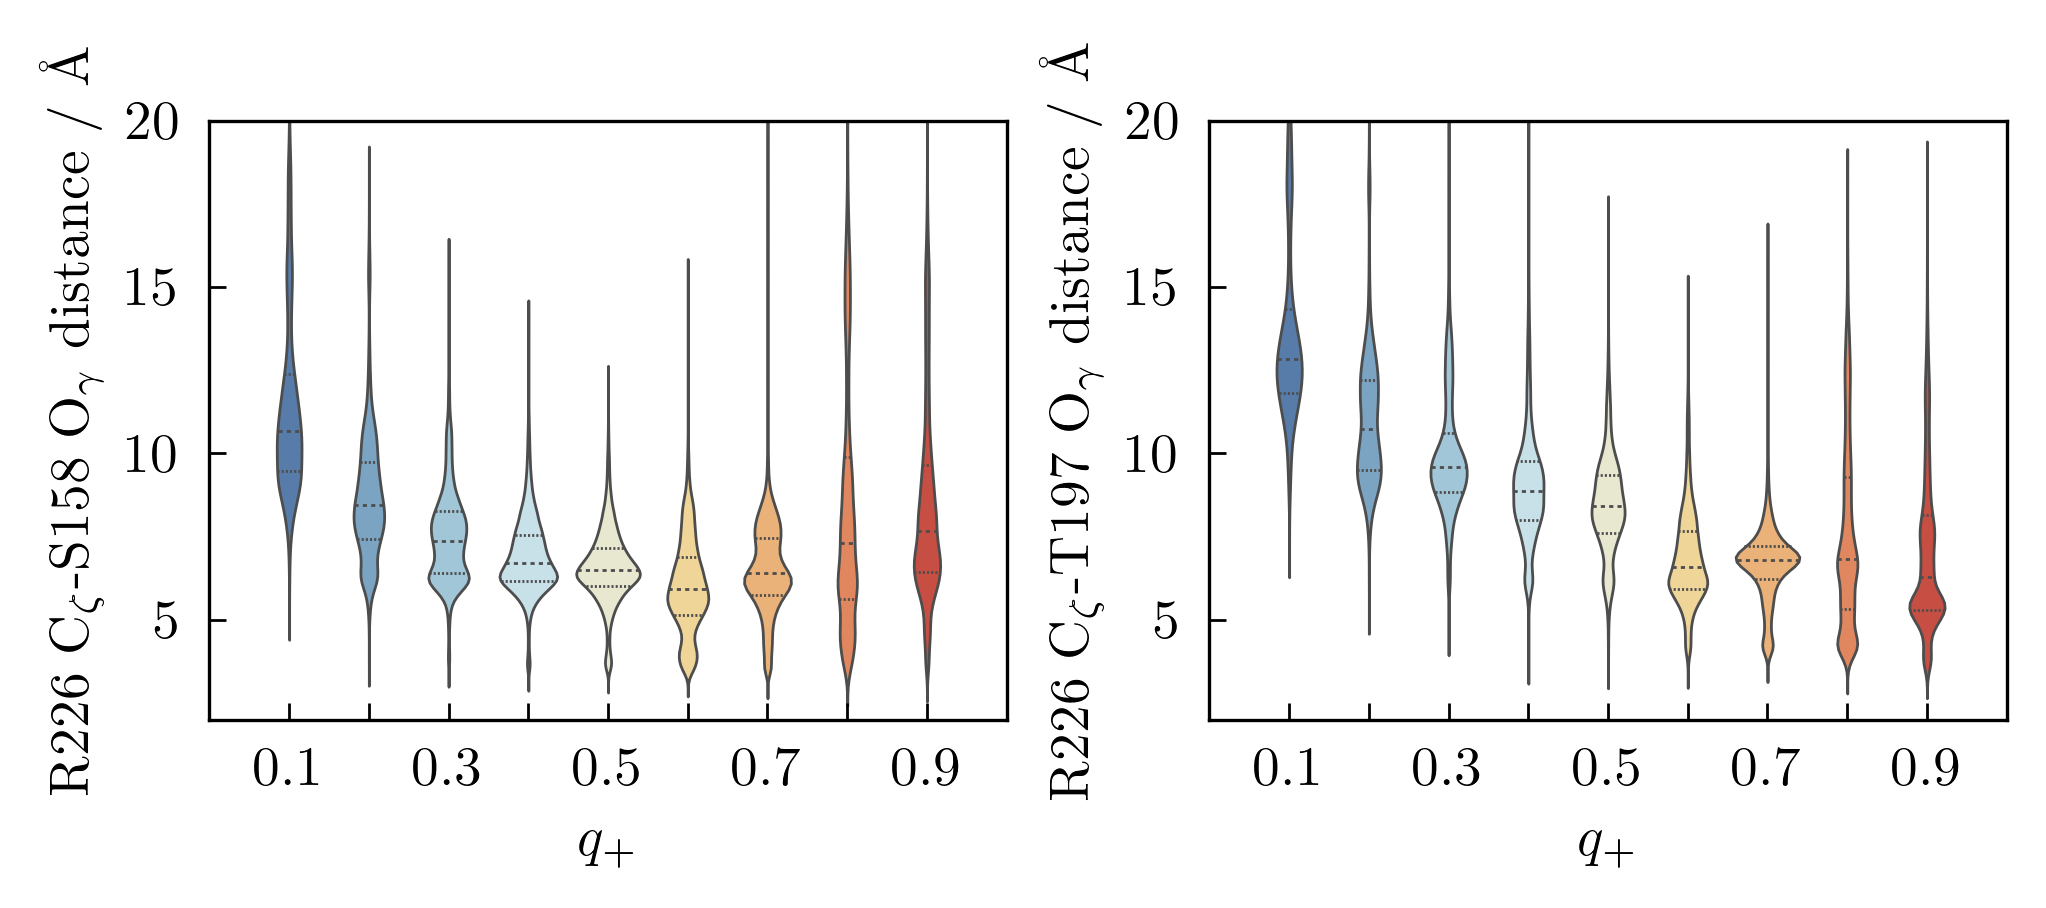

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=200, constrained_layout=True, sharex=True)
# S158
sns.violinplot(
    ax=axes[0],
    data=[dist_arr[inds, 0] * 10 for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5
)
# T197
sns.violinplot(
    ax=axes[1],
    data=[dist_arr[inds, 1] * 10 for inds in q_inds],
    scale="area",
    bw=0.1,
    inner="quartile",
    palette="diverging",
    orient="v",
    linewidth=0.5
)
for ax in axes:
    ax.set_xticklabels(steplabels)
    ax.set_xlabel("$q_+$")
    ax.set_xlim([-1, 9])
    ax.set_ylim([2, 20])
axes[0].set_ylabel(r"R226 C$_\zeta$-S158 O$_\gamma$ distance / $\textrm{\AA}$")
axes[1].set_ylabel(r"R226 C$_\zeta$-T197 O$_\gamma$ distance / $\textrm{\AA}$")

## vs. Committor

/scratch/local/jobs/3920420/ipykernel_1832981/3514907753.py:16: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


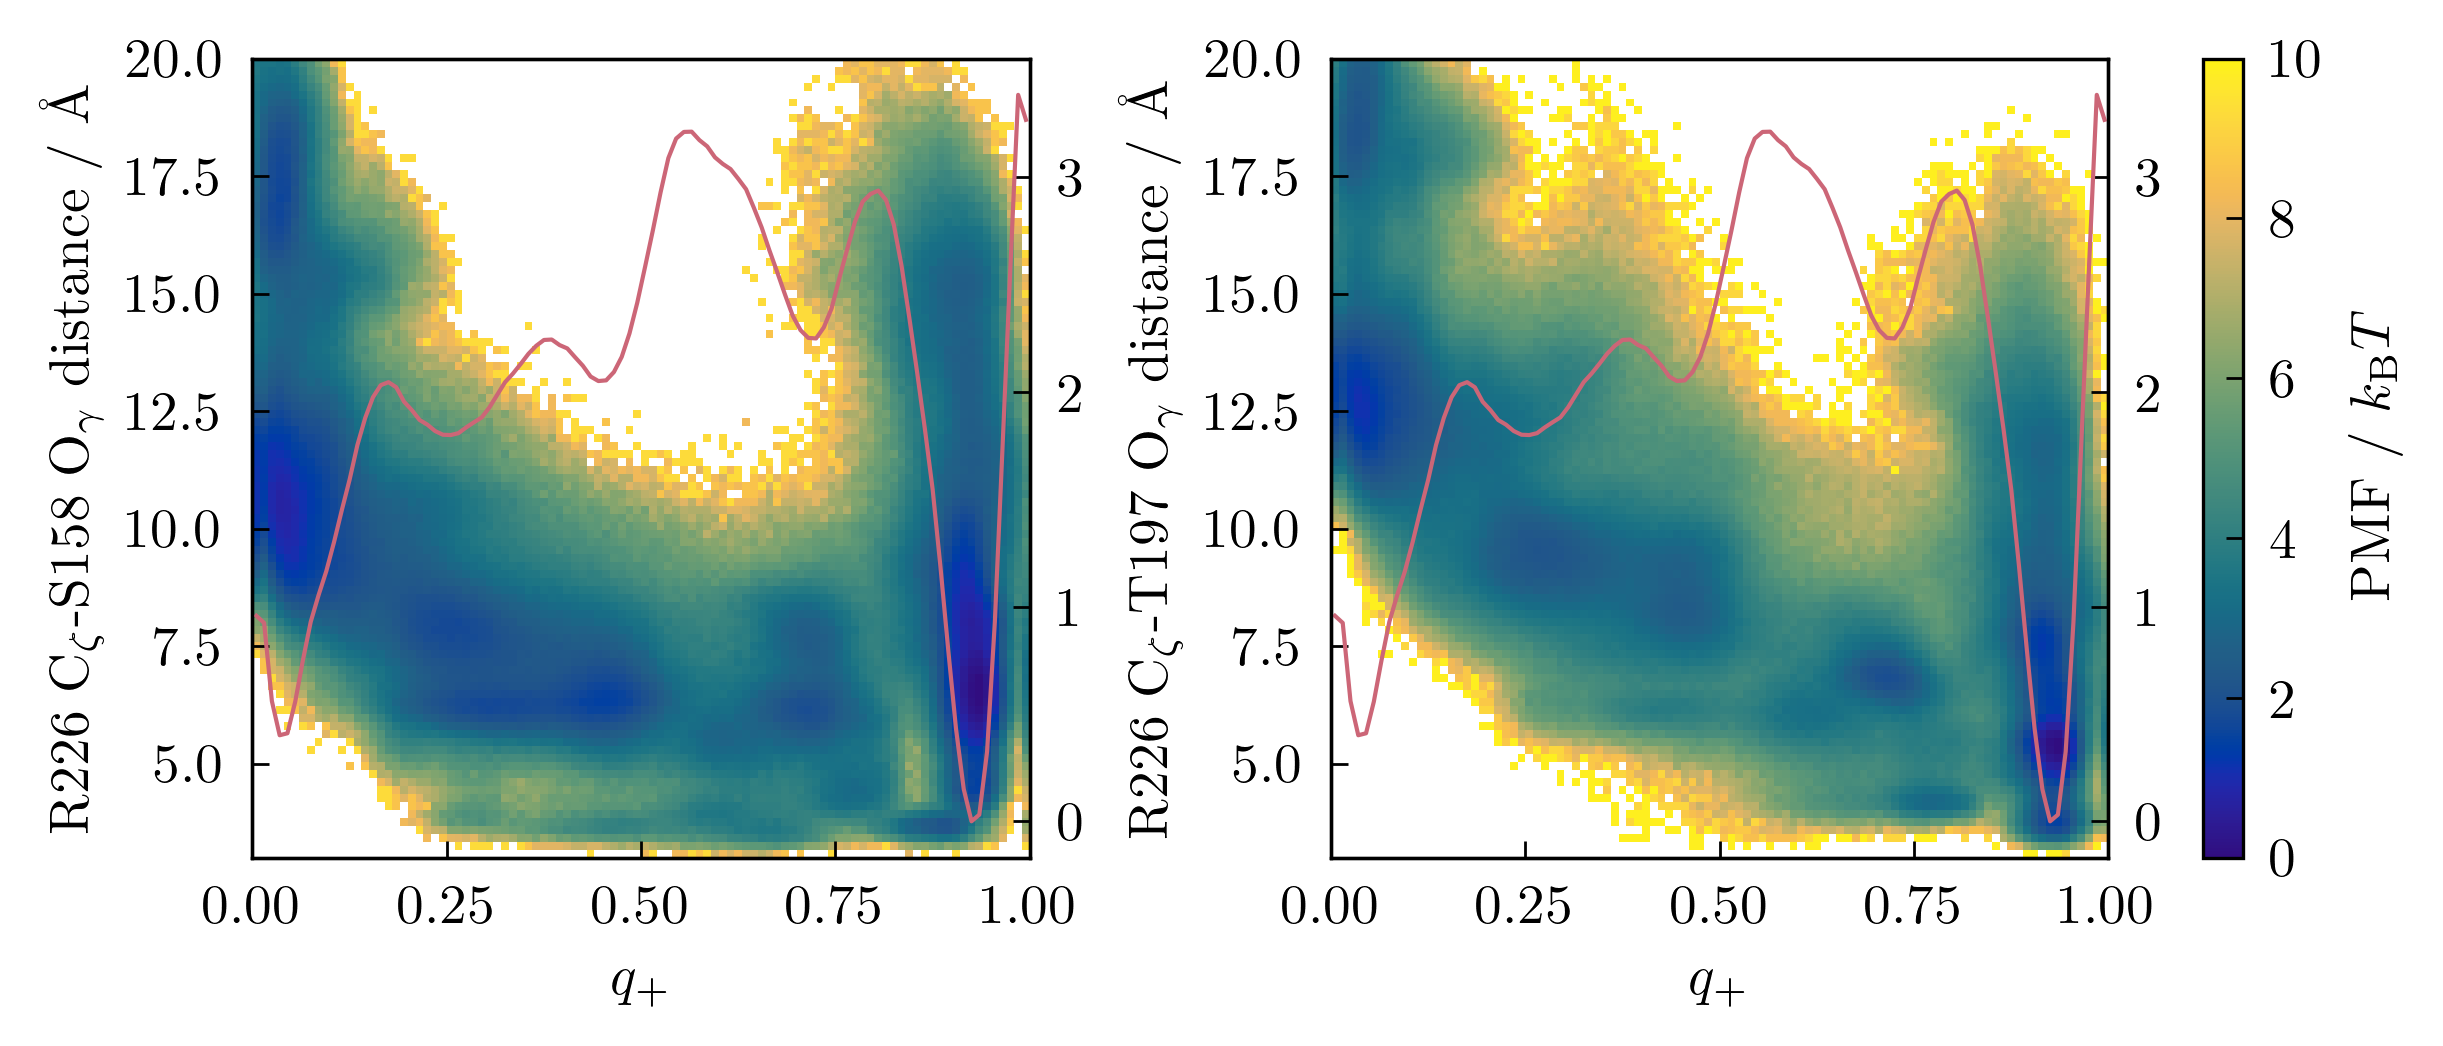

In [23]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5), dpi=200, constrained_layout=True)
lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

yedges = [np.linspace(3, 20, 101), np.linspace(3, 20, 101)]

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

for i, (ax, ye) in enumerate(zip(axes, yedges)):
    cv_nodelay = [traj[:, i] * 10 for traj in distances]
    pmf = extq.projection.density2d(qp_du, cv_nodelay, weights, qe, ye)
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf) - min_energy
    pc0 = ax.pcolormesh(qe, ye, diff.T, cmap='macaw', vmin=0, vmax=10)
    ax_new = ax.twinx()
    ax_new.plot(qc, q_pmf)
    # ax.axhline(sb_models[1, sb] * 10, ls='--', color='black')
    # ax.axhline(sb_models[2, sb] * 10, ls='-.', color='black')
    ax.set_xlabel("$q_+$")
    
axes[0].set_ylabel(r"R226 C$_\zeta$-S158 O$_\gamma$ distance / $\textrm{\AA}$")
axes[1].set_ylabel(r"R226 C$_\zeta$-T197 O$_\gamma$ distance / $\textrm{\AA}$")
plt.colorbar(pc0, ax=axes[1], location="right", label="PMF / $k_{\\rm B}T$")

# Hydrogen bonding

In [18]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

In [19]:
from joblib import Parallel, delayed
from multiprocess import cpu_count

n_jobs = cpu_count()

In [20]:
HOME_DIR = "/project/dinner/scguo/ci-vsd"

In [21]:
u = mda.Universe(f"{HOME_DIR}/civsd-pro.psf", files[0])

In [22]:
for a in u.select_atoms("protein and resid 226 and not backbone and type NC2"):
    print(a)
for a in u.select_atoms("protein and resid 158 and not backbone and name OG"):
    print(a)
for a in u.select_atoms("protein and resid 197 and not backbone and name OG1"):
    print(a)

<Atom 1946: NE of type NC2 of resname ARG, resid 226 and segid A>
<Atom 1949: NH1 of type NC2 of resname ARG, resid 226 and segid A>
<Atom 1952: NH2 of type NC2 of resname ARG, resid 226 and segid A>
<Atom 851: OG of type OH1 of resname SER, resid 158 and segid A>
<Atom 1478: OG1 of type OH1 of resname THR, resid 197 and segid A>


In [23]:
def hbond_anton(trajfile, cutoff=3.5, angle=120):
    u = mda.Universe(f"{HOME_DIR}/civsd-pro.psf", trajfile)
    r_sel = f"protein and resid 226 and not backbone and type NC2"
    s158 = f"protein and resid 158 and not backbone and name OG"
    t197 = f"protein and resid 197 and not backbone and name OG1"
    hbonds_s158 = HydrogenBondAnalysis(
        universe=u,
        between=[r_sel, s158],
        d_a_cutoff=cutoff,
        d_h_a_angle_cutoff=angle,
        update_selections=False
    )
    hbonds_t197 = HydrogenBondAnalysis(
        universe=u,
        between=[r_sel, t197],
        d_a_cutoff=cutoff,
        d_h_a_angle_cutoff=angle,
        update_selections=False
    )
    return hbonds_s158, hbonds_t197


def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [24]:
analysis_ensemble = [hbond_anton(f) for f in files]

In [25]:
s158_hb = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis[0]) for analysis in analysis_ensemble
)
t197_hb = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis[1]) for analysis in analysis_ensemble
)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:751: UserWarning: No hydrogen bonds were found given angle of 120 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLN and name OT1) or (resname GLN and name OY) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HSD and name NE2) or (resname HSD and name O) or (resname ILE and name O) or (

(array([4039144.,       0.,       0.,       0.,       0.,  101541.,
              0.,       0.,       0.,    9430.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

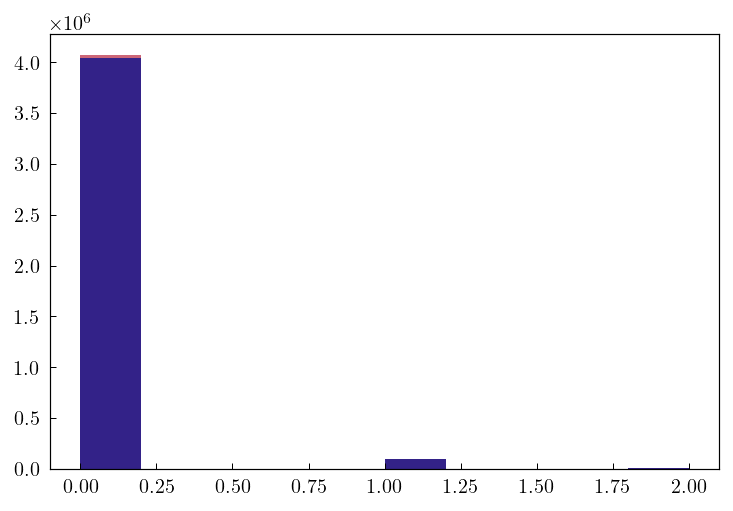

In [128]:
plt.hist(np.concatenate(s158_hb))
plt.hist(np.concatenate(t197_hb))

In [26]:
np.save(f"{DATA_DIR}/raw_feat/s158_r226_hb.npy", s158_hb)
np.save(f"{DATA_DIR}/raw_feat/t197_r226_hb.npy", t197_hb)

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [27]:
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights]

qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

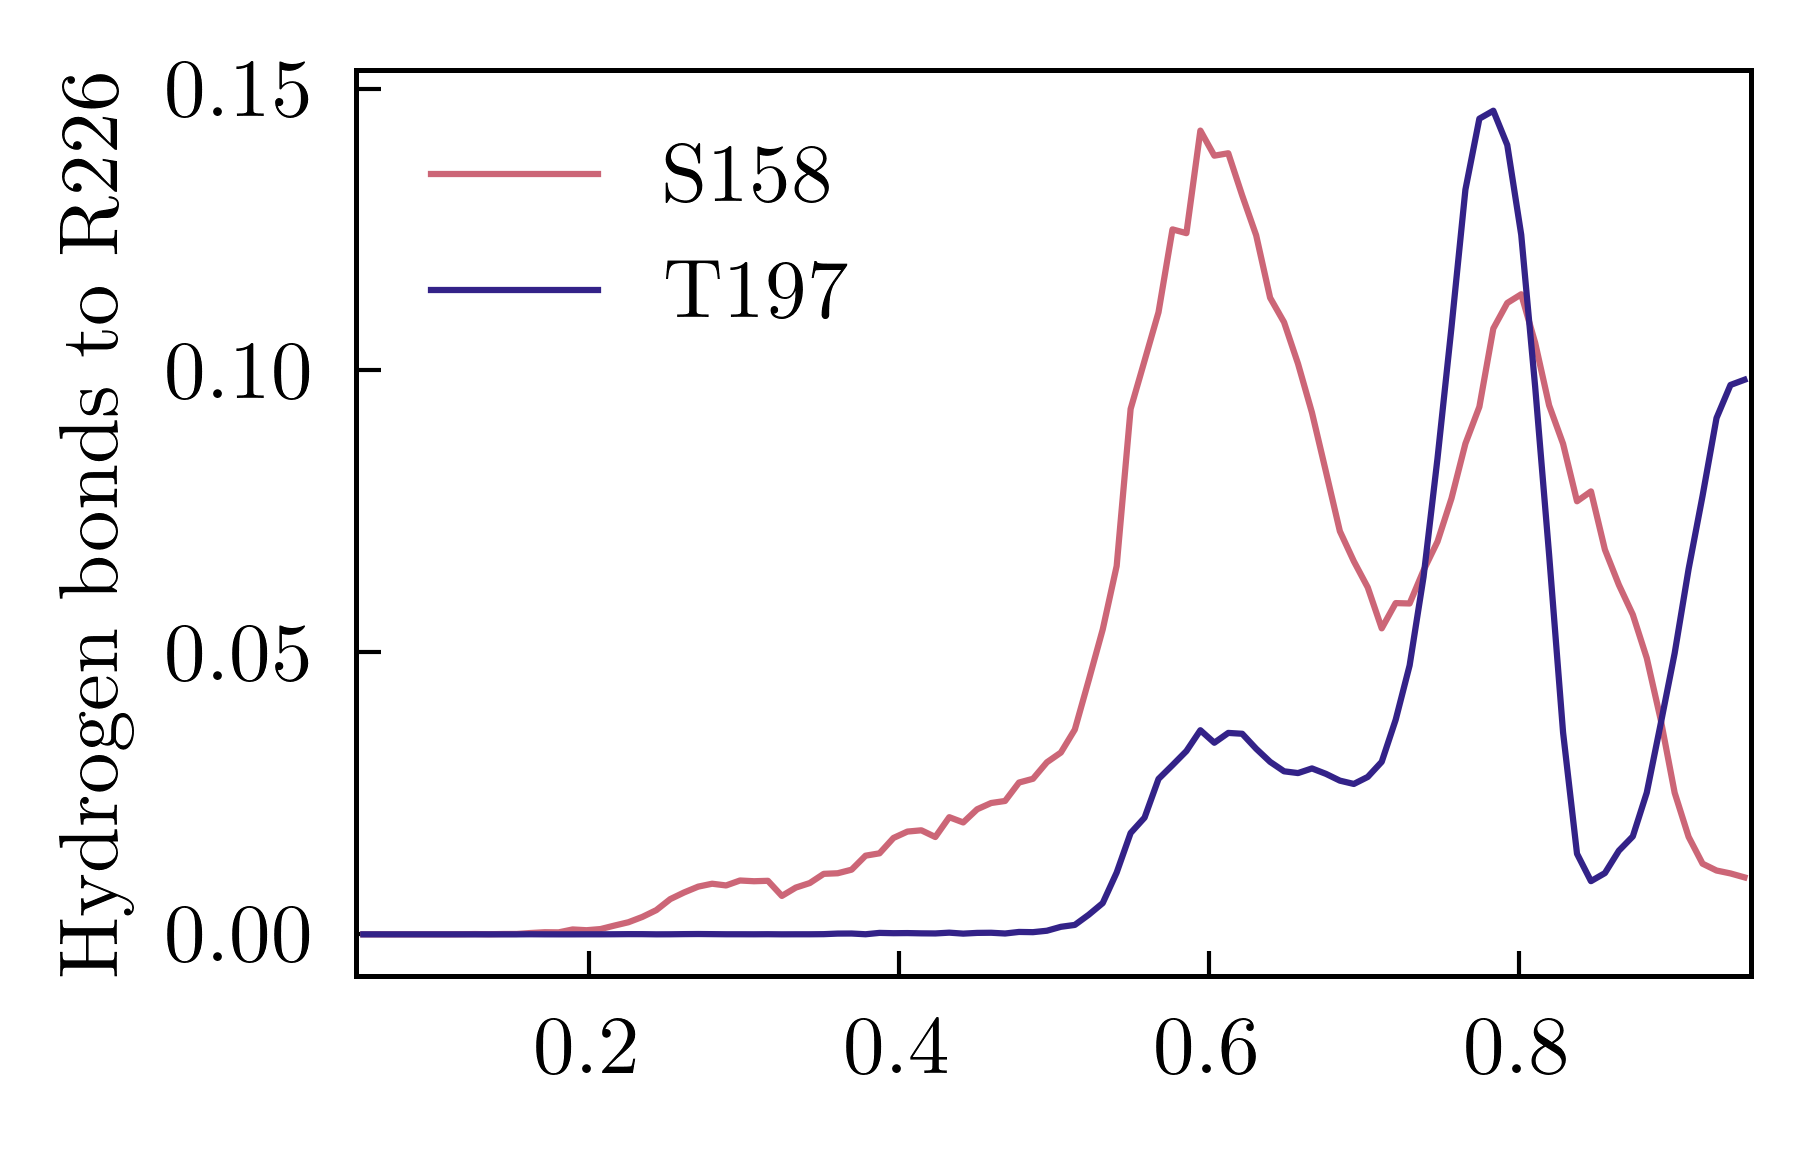

In [31]:
f, ax = plt.subplots(figsize=(3.0, 2), dpi=300)
lo, hi = 0.05, 0.95
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

for hb in (s158_hb, t197_hb):
    hb_traj = util.smooth_moving_average([t[:-lag] for t in hb], 10, n=2)
    q_dens = extq.projection.average1d(qp_delay, hb_traj, w_delay, qe)
    ax.plot(qc, q_dens)

plt.xlim([lo, hi])
# plt.ylim([0, 2.0])
plt.ylabel("Hydrogen bonds to R226")
leg = plt.legend(["S158", "T197"])